Ibexmop-server (Example)
===

**Conexión por SSH**

In [6]:
import ibex
ssh = ibex.connect("158.251.88.197")

login: iaraya
pass: ········


Función que itera en el solver y retorna puntos que definen *envelopes*

In [7]:
#tan.txt
def ctc(x1,x2):
    c1 = -x1**2 - x2**2 + 1 + 0.1*np.cos(16*np.arctan(x1/x2)) <= 0
    c2 = 2*(x1-0.5)**2+2*(x2-0.5)**2-1 <=0
    return c1&c2

def z1(x1,x2):
    return ctc(x1,x2) * x1

def z2(x1,x2):
    return ctc(x1,x2) * x2

#ibex.get_instances()

In [8]:
import numpy as np

x = np.linspace(0.44, 0.5, 120)
y = np.linspace(0.8, 0.95, 120)

X, Y = np.meshgrid(x, y)
Z1 = z1(X, Y)
Z2 = z2(X, Y)

Cargando ibex...
killall ibexmop-server; /home/iaraya/ibex/ibex-lib/__build__/plugins/optim-mop/ibexmop-server /home/iaraya/ibex/ibex-lib/plugins/optim-mop/benchs/binh.txt --port=8087 --server_mode --ub=no --cy-contract-full
echo run 50 1e-08 | netcat localhost 8087
run executed
killall ibexmop-server; /home/iaraya/ibex/ibex-lib/__build__/plugins/optim-mop/ibexmop-server /home/iaraya/ibex/ibex-lib/plugins/optim-mop/benchs/binh.txt --port=8087 --server_mode --ub=ub1 --cy-contract-full
echo run 50 1e-08 | netcat localhost 8087
run executed
killall ibexmop-server; /home/iaraya/ibex/ibex-lib/__build__/plugins/optim-mop/ibexmop-server /home/iaraya/ibex/ibex-lib/plugins/optim-mop/benchs/binh.txt --port=8087 --server_mode --ub=ub3 --cy-contract-full
echo run 50 1e-08 | netcat localhost 8087
run executed
[21.836968, 24.027761, 21.349809, 22.416113]


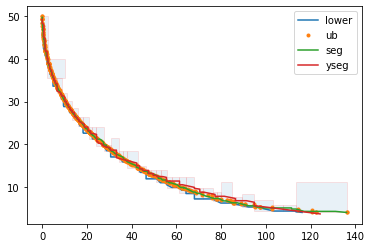

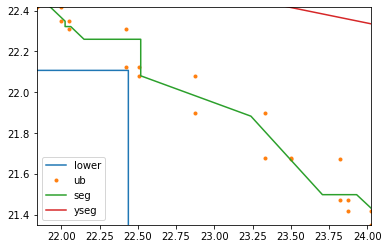

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import random
import importlib
importlib.reload(ibex)
ibex.ssh=ssh

instance = "binh.txt"

it = 50
channel = ibex.init_mopserver(instance, port=8087)
ibex.run(it, 1e-8, port=8087)
l1,l2,u1,u2 = ibex.get_envelope(port=8087)

channel = ibex.init_mopserver(instance, port=8087, ub='ub1')
ibex.run(it, 1e-8, port=8087)
_,_,uu1,uu2 = ibex.get_envelope(port=8087)

channel = ibex.init_mopserver(instance, port=8087, ub='ub3')
ibex.run(it, 1e-8, port=8087)
_,_,uuu1,uuu2 = ibex.get_envelope(port=8087)


#p = [0.48, 0.88]

%matplotlib inline 
#plot
boxes = ibex.get_boxes(port=8087)
ibex.add_boxes(boxes, plt)
#plt.plot(Z1,Z2, 'r.', alpha=0.2); 
plt.plot(l1, l2, '-', u1,u2,'.', uu1, uu2, '-', uuu1, uuu2,  '-'); 
plt.legend(['lower','ub', 'seg', 'yseg'], loc='best'); 
p = random.randint(10,len(u1)-10)
print([u1[p-10], u1[p+10], u2[p+10], u2[p-10]])
plt.show()
#ibex.add_boxes(boxes, plt)
plt.plot(l1, l2, '-', u1,u2,'.', uu1, uu2, '-', uuu1, uuu2,  '-'); 
plt.legend(['lower','ub', 'seg', 'yseg'], loc='best'); 
plt.axis([u1[p-10], u1[p+10], u2[p+10], u2[p-10]])
#plt.axis([2, 3, -6, -4])
plt.show()

In [4]:
ibex.close_mopserver()

[]


RPM
---
When a **reference point** is indicated, the focus region changes to the region dominated by the reference point. If such solution does not exist, then the objectives of the search change to find a solution minimizing its distance to the reference point.

**Implementación**

Asumiendo que $r$ es el punto de referencia.
Activar estado a `RPM-phase1`

**RPM-phase1**
1. Primero habría que actualizar el refpoint a $r$ (`update_refpoint`).
2. Realizar la búsqueda (`run`) hasta encontrar una solución mejor al punto de referencia. En caso de encontrar, desactivar estado RPM y volver a la normalidad.
3. En caso de que `run` retorne `REACHED_PRECISION` pasar a estado `RPM-phase2`

**RPM-phase2**
1. Usar `SearchEfficient` y pasarle las cajas del focus. El objetivo sería encontrar el punto $y'$ que minimiza:
$max(y'_1-r_1, y'_2-r_2) + \rho (y'_1 + y'_2)$
Se puede comenzar usando el punto del upper envelope que minimiza la función.
2. Luego de encontrar el punto, las cajas restantes reemplazan a las cajas del focus originales. Se desactiva el estado RPM y todo vuelve a la normalidad.
3. En cualquier momento el usuario puede desactivar el estado RPM. Si lo hace, las cajas del focus vuelven a la estrategia original. Para poder detener la búsqueda es necesario implementar función `run` en SearchEfficient al igual que en el solver interactivo. En este caso, la única opción posible sería detener el RPM para continuar con la búsqueda normal.
En la interfaz se podría bloquear la interacción hasta que termine RPM o el usuario decida detenerlo.

![image](https://i.imgur.com/ygIVkOz.png)


